Step 1: Generate Synthetic Temperature Data
We'll create synthetic daily temperature data that generally follows a realistic seasonal pattern but includes some random noise and anomalies.

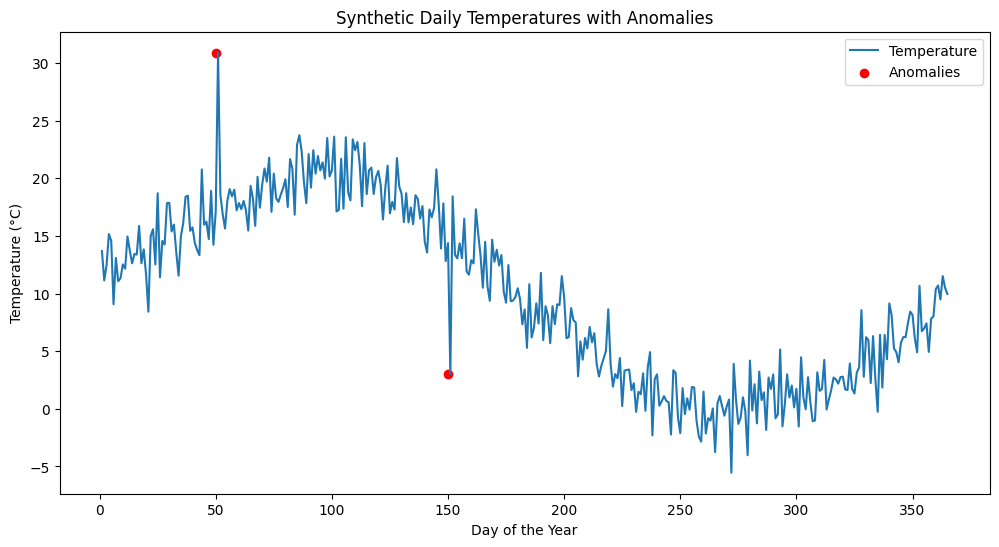

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(0)

# Generate synthetic daily temperatures following a sinusoidal pattern
days = np.arange(1, 366)  # 365 days for one year
base_temperature = 10 + 10 * np.sin(2 * np.pi * days / 365)  # Base temperature with seasonal variation
noise = np.random.normal(scale=2, size=len(days))  # Random temperature fluctuations
data = base_temperature + noise

# Introduce anomalies (extreme temperatures)
data[50] += 15  # A hot spike anomaly
data[150] -= 12  # A cold drop anomaly

# Plot the synthetic temperature data
plt.figure(figsize=(12, 6))
plt.plot(days, data, label='Temperature')
plt.scatter([50, 150], [data[50], data[150]], color='red', label='Anomalies')
plt.title("Synthetic Daily Temperatures with Anomalies")
plt.xlabel("Day of the Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


Step 2: Preprocess Data for LSTM
For LSTM models, data should be sequenced properly. Let’s use a sequence length of 30 days to predict the next day’s temperature.

In [2]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM


Step 3: Build and Train the LSTM Model
We'll use a simple LSTM architecture for temperature prediction.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X, y, epochs=20, verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
11/11 [==============================] - 1s 4ms/step - loss: 48.8091
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 13.6123
Epoch 3/20
11/11 [==============================] - 0s 3ms/step - loss: 10.9910
Epoch 4/20
11/11 [==============================] - 0s 3ms/step - loss: 9.6340
Epoch 5/20
11/11 [==============================] - 0s 3ms/step - loss: 8.3017
Epoch 6/20
11/11 [

Step 4: Anomaly Detection
Predict the series and use the 2-sigma rule to identify anomalies in temperature readings.

11/11 [==============================] - 0s 1ms/step


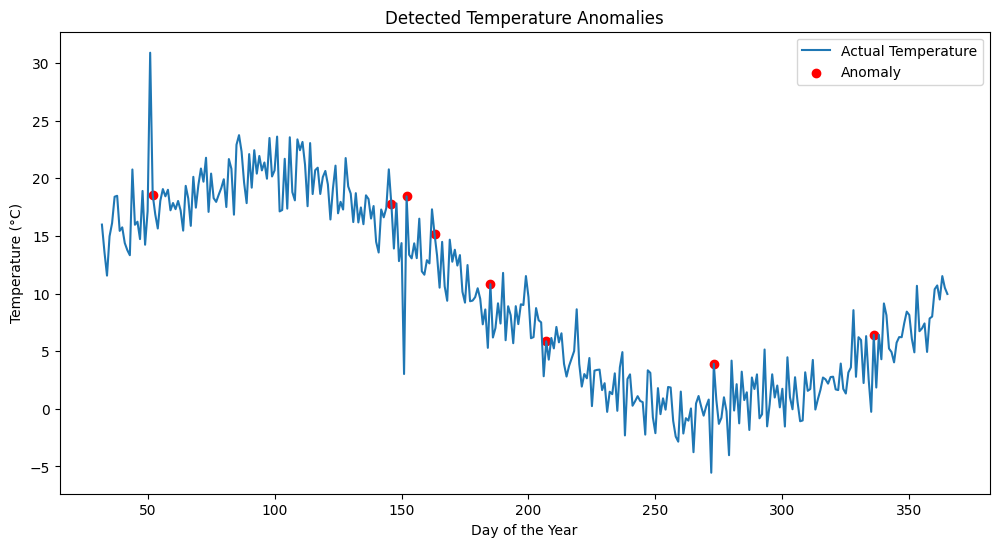

In [7]:
predictions = model.predict(X).flatten()

errors = np.abs(predictions - y)
mean_error = np.mean(errors)
std_error = np.std(errors)
threshold = mean_error + 2 * std_error
anomalies = errors > threshold

plt.figure(figsize=(12, 6))
plt.plot(days[seq_length+1:], data[seq_length+1:], label='Actual Temperature')
plt.scatter(days[seq_length+1:][anomalies], data[seq_length+1:][anomalies], color='r', label='Anomaly')
plt.title("Detected Temperature Anomalies")
plt.xlabel("Day of the Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


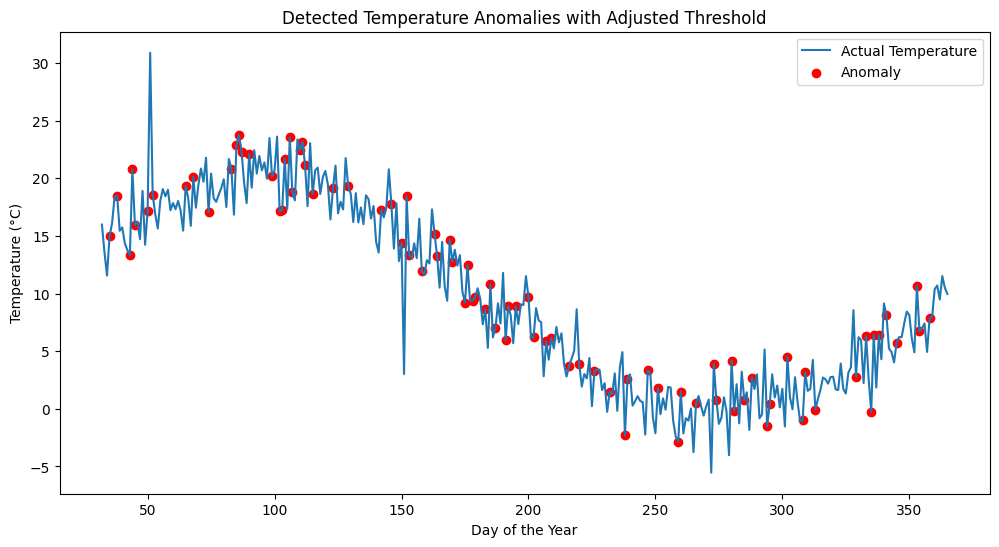

In [10]:
# Experiment with a different threshold
new_threshold = mean_error + 0.5 * std_error  # Lowering the threshold

# Identify new anomalies with the adjusted threshold
new_anomalies = errors > new_threshold

plt.figure(figsize=(12, 6))
plt.plot(days[seq_length+1:], data[seq_length+1:], label='Actual Temperature')
plt.scatter(days[seq_length+1:][new_anomalies], data[seq_length+1:][new_anomalies], color='r', label='Anomaly')
plt.title("Detected Temperature Anomalies with Adjusted Threshold")
plt.xlabel("Day of the Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [ ]:
Sensibilidad del Modelo: El modelo LSTM podría no ser lo suficientemente sensible para capturar las diferencias sutiles entre las variaciones normales y las anomalías, especialmente si las anomalías no son significativamente diferentes de las variaciones normales.

Umbral de Error: El umbral basado en la regla de 2-sigma podría no estar adecuadamente ajustado para este conjunto de datos en particular. Si las fluctuaciones de temperatura son generalmente grandes, el umbral calculado podría ser demasiado alto, dificultando la detección de anomalías menores.

Preprocesamiento de Datos: Si el preprocesamiento de datos (como el escalado) no se maneja correctamente, podría afectar la capacidad del modelo para aprender de manera efectiva. Para la detección de anomalías, es importante mantener la escala original para capturar verdaderas anomalías.

Longitud de la Secuencia: La elección de la longitud de la secuencia podría impactar el rendimiento del LSTM. Una secuencia muy larga podría diluir el efecto de una anomalía si la secuencia contiene principalmente datos normales.